In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
from glob import glob
from tqdm import tqdm
from pathlib import Path
import re

%matplotlib widget
import matplotlib as mp
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm, Normalize, LogNorm
from matplotlib.patches import ConnectionPatch
import textwrap

import functions_calcs as fc
import functions_plotting as fp

SAVE_PLOTS = True

norm = TwoSlopeNorm(vmin=-0.5, vcenter=0, vmax=0.5)
cmap = 'RdBu'

proj_path = Path('/work/pi_kandread_umass_edu/Cloud_Freq/')
figure_path = proj_path / "figures" 

daily_data_file = proj_path / 'data' / 'analysis_data_daily.parquet'
df = pd.read_parquet(daily_data_file, engine='pyarrow')

sites_data_file = proj_path / 'data' / 'analysis_data_sites.parquet'
sites = gpd.read_parquet(sites_data_file)

resampled_sites_data_file = proj_path / 'data' / 'analysis_data_resampled_sites.pkl'
resampled_sites = pd.read_pickle(resampled_sites_data_file)
cols = []
for col in resampled_sites.columns.values:
    if col[0]=='sites':
        cols.append(f"{col[1]}")
    else:
        cols.append(f"{col[0]}_{col[1]:1.2f}")
resampled_sites.columns = cols

basins_data_file = proj_path / 'data' / 'analysis_data_basins.parquet'
hydroBasins = gpd.read_parquet(basins_data_file)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.to_crs('World_Robinson')

print("Done!")

/tmp/ipykernel_2769440/3526334629.py:47: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


Done!


In [ ]:
def cloud_line_plot(df_in: pd.DataFrame,
                    sites_in: pd.DataFrame,
                    ax,
                    col_name: str,
                    bin_bounds: list,
                    label_fmt_func,
                    legend_title: str):

    # Create a color cycle with a continuous colormap
    colors = plt.cm.viridis(np.linspace(0, 1, len(bin_bounds)-1))
    ax.set_prop_cycle('color', colors)

    # Plot each site ID's time series
    for lower_limit, upper_limit in zip(bin_bounds, bin_bounds[1:]):
        sites_size_bin = (sites_in[(sites_in[col_name]>=(lower_limit)) & 
                                   (sites_in[col_name]<(upper_limit))])
        df_size_bin = df_in[df_in.index.get_level_values('id').isin(sites_size_bin.index)]

        df_grouped = df_size_bin.groupby('quantile_bin')['cloud_class'].value_counts(normalize=True).unstack('cloud_class')
        df_grouped = df_grouped[(df_grouped.index > 0) & (df_grouped.index < 11)]

        low_string = label_fmt_func(lower_limit)
        high_string = label_fmt_func(upper_limit)

        ax.plot(df_grouped.index,
                df_grouped['No Cloud'],
                label=f"{low_string}-{high_string}\nn={len(sites_size_bin)}")

    ax.set_xticks(np.linspace(2,10,5))
    new_labels = [f'{label * 0.1:.1f}' for label in ax.get_xticks()]
    ax.set_xticklabels(new_labels, rotation=0)

    ax.set_ylim([0.23,0.6])
    ax.set_yticks(np.linspace(0.25,0.55,4))

    # Adjust layout and show the plots
    # plt.subplots_adjust(left=0.1, right=0.7)
    ax.legend(title=legend_title, loc='upper left', bbox_to_anchor=(1, 1.045))
    ax.set_xlabel('Discharge Quantile')
    ax.set_ylabel('Proportion Clear')

plt.close('all')

# Create subplots
fig, axes = plt.subplot_mosaic([['ul','ur'],
                                ['bl','br']],
                               figsize = (8,5.5))

#Top left
fp.cloud_bar_plot(df, axes['ul'])
axes['ul'].set_title("All Reaches")
handles, labels = axes['ul'].get_legend_handles_labels()
handles.reverse()  # Reverse the order of handles
labels.reverse()   # Reverse the order of labels
axes['ul'].legend(handles, labels, title='Legend Title', loc='upper left', bbox_to_anchor=(1, 1.045))

#Top right
col_name = 'Q'
bin_bounds = [1E0, 1E1, 1E2, 1E3, 1E4, 1E6]
label_fmt_func = lambda x: f'$10^{np.log10(x):1.0f}$'
cloud_line_plot(df,sites,axes['ur'],col_name,bin_bounds,label_fmt_func,'Discharge [$m^3/s$]')
axes['ur'].set_title("By Discharge")

#Bottom left
col_name = 'temperature_2m'
bin_bounds = [x+273.15 for x in [0,10,15,20,25,30]]
label_fmt_func = lambda x: f'{x-273.15:.0f}'
cloud_line_plot(df,sites,axes['bl'],col_name,bin_bounds,label_fmt_func,'Temperature [C]')
axes['bl'].set_title("By Temperature")

#Bottom right
col_name = 'slope'
bin_bounds = [1E-6, 1E-4, 1E-3, 1E-2, 1E0]
label_fmt_func = lambda x: f'$10^{{ {np.log10(x):1.0f} }}$'
cloud_line_plot(df,sites,axes['br'],col_name,bin_bounds,label_fmt_func, 'Slope [m/m]')
axes['br'].set_title("By Slope")

axes['ul'].text(0, 1.1, 'a', transform=axes['ul'].transAxes, fontsize=14, fontweight='bold', va='top')
axes['ur'].text(0, 1.1, 'b', transform=axes['ur'].transAxes, fontsize=14, fontweight='bold', va='top')
axes['bl'].text(0, 1.1, 'c', transform=axes['bl'].transAxes, fontsize=14, fontweight='bold', va='top')
axes['br'].text(0, 1.1, 'd', transform=axes['br'].transAxes, fontsize=14, fontweight='bold', va='top')

plt.tight_layout()
if SAVE_PLOTS:
    fig.savefig(figure_path  / "pub" / "Figure1.2.png", format='png', dpi=600)

In [ ]:
plt.close('all')
fig, axes = plt.subplot_mosaic([['left','left','right','right','legend1'],
                              ['left','left','right','right','legend2']],
                            figsize=(8,3))

# All Reaches
fp.cloud_bar_plot(df, axes['left'])
axes['left'].get_legend().remove()

# By Discharge
col_plot = 'Q'
river_sizes = [1E0, 1E1, 1E2, 1E3, 1E4, 1E6]
colors = plt.cm.viridis(np.linspace(0, 1, len(river_sizes)-1))
fp.split_cloud_plot(sites,df, col_plot, river_sizes, colors, axes['right'])

#Format the overall figure
# Place the legends on the respective axes
legend_args = {
    'fontsize': 10,
    'markerscale': 0.8,
    'loc': 'center right'
}
axes['legend1'].legend(*axes['left'].get_legend_handles_labels(), title='Cloud Class', **legend_args)
axes['legend1'].axis('off')
axes['legend2'].legend(*axes['right'].get_legend_handles_labels(), title='Discharge [$m^3/s$]', **legend_args)
axes['legend2'].axis('off')

# Add subplot labels
axes['left'].text(0, 1.1, 'a', transform=axes['left'].transAxes, fontsize=14, fontweight='bold', va='top')
axes['right'].text(0, 1.1, 'b', transform=axes['right'].transAxes, fontsize=14, fontweight='bold', va='top')

plt.tight_layout()

if SAVE_PLOTS:
    fig.savefig(figure_path / "pub" / "Figure1.png", format='png', dpi=600)

Text(0.05, 0.9, 'c')

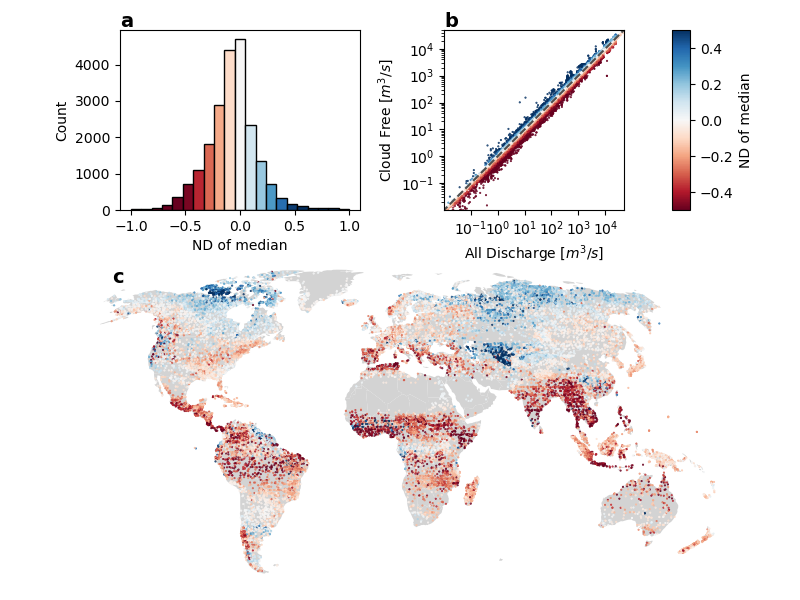

In [95]:
plt.close('all')

fig = plt.figure(figsize=(8, 6))
axes = dict()
axes['left'] = fig.add_axes([0.15, 0.65, 0.3, 0.3])  # [left, bottom, width, height]
axes['right'] = fig.add_axes([0.5, 0.65, 0.4, 0.3])
axes['center'] = fig.add_axes([0.1, 0, 0.8, 0.65])

#Histogram
hist, bins = np.histogram(sites['normDiff_q50'], range=(-1, 1), bins=21)
widths = np.diff(bins)

# Create the histogram bars with colors according to the norm and cmap
for h,b,w in zip(hist,bins,widths):
    color = plt.get_cmap(cmap)(norm(b+w/2)) # Normalize the histogram value and get the corresponding color
    axes['left'].bar(b, h, width=w, align='edge', color=color, edgecolor='black')
axes['left'].set_xlabel("ND of median")
axes['left'].set_ylabel("Count")

#1:1 plot
fp.obs_true_1to1(df,50,axes['right'])
axes['right'].set_xlabel('All Discharge [$m^3/s$]')
axes['right'].set_ylabel('Cloud Free [$m^3/s$]')
axes['right'].set_xticks(np.logspace(-1,5,7))
axes['right'].set_yticks(np.logspace(-1,5,7))
axes['right'].set_xlim([1E-2,5E4])
axes['right'].set_ylim([1E-2,5E4])
    
# Plot world map                  
world.plot(ax=axes['center'], color='lightgray')

# Plot all sites on the center map
sites.plot(ax=axes['center'], marker='o', column='normDiff_q50', markersize=0.25, cmap=cmap, norm=norm)

# Add color bar
fig.colorbar(mp.cm.ScalarMappable(norm=norm, cmap=cmap), 
             ax = axes['right'], 
             location = 'right',
             pad = 0.15,
             aspect = 10,
             label = 'ND of median')

# axes['center'].set_title('Normalized Difference at Median',y=0.9)
axes['center'].set_xlim([-1.4E7, 1.6E7])
axes['center'].set_ylim([-6E6, 1E7])
axes['center'].axis('off')

axes['left'].text(0, 1.1, 'a', transform=axes['left'].transAxes, fontsize=14, fontweight='bold', va='top')
axes['right'].text(0, 1.1, 'b', transform=axes['right'].transAxes, fontsize=14, fontweight='bold', va='top')
axes['center'].text(0.05, 0.9, 'c', transform=axes['center'].transAxes, fontsize=14, fontweight='bold', va='top')

if SAVE_PLOTS:
    fig.savefig(figure_path / "pub" / "Figure2.png", format='png', dpi=600)

In [ ]:
import importlib
importlib.reload(fp)

plt.close('all')
fig, axes = plt.subplot_mosaic([['l0','lm0','lr0','r0'],
                                ['center']*4,
                                ['center']*4,
                                ['center']*4,
                                ['l4','lm4','lr4','r4']],
                               figsize = (8,8))
plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.15, wspace=0.05, hspace=0)

callout_list = [['l0',82,'Mackenzie R.',(0,0)],
                ['lm0',74,'Mississippi R.',(0,0)],
                ['lr0',46,'Central Asia',(0,0)],
                ['r0',34,'Lena R.',(0,0)],
                ['l4',62,'Amazon R.',(1,1)],
                ['lm4',14,'W. Africa',(1,1)],
                ['lr4',44,'S.E. Asia',(1,1)],
                ['r4',43,'Yangtze R.',(1,1)]]
              
tmp = df
tmp['l2'] = tmp.index.get_level_values('id')//1E6

monthly1 = tmp.groupby(['id','month']).mean(numeric_only=True)
monthly = monthly1.groupby(['l2', 'month']).agg({
    'Q_norm': [
        ('count', 'count'),   # Count
        ('mean', 'mean'),     # Mean
        ('p10', lambda x: x.quantile(0.1)),  # 10th percentile
        ('p90', lambda x: x.quantile(0.9))   # 90th percentile
    ],
    'cloudMask': [
        ('count', 'count'),   # Count
        ('mean', 'mean'),     # Mean
        ('p10', lambda x: x.quantile(0.1)),  # 10th percentile
        ('p90', lambda x: x.quantile(0.9))   # 90th percentile
    ]
})


norm = TwoSlopeNorm(vmin=-0.5, vcenter=0, vmax=0.5)
cmap = 'RdBu'
fp.pfaf_level2_plot(hydroBasins,'normDiff_q50',cmap, norm, axes['center'])
# sites.plot(ax=axes['center'], marker='o', column=f'normDiff_q{quant:02.0f}', markersize=0.5, cmap=cmap, norm=norm)
axes['center'].set_xlim([-1.4E7, 1.6E7])
axes['center'].set_ylim([-6E6, 9E6])
axes['center'].axis('off')

pos = axes['center'].get_position()  # Get the current position
new_pos = [pos.x0, pos.y0, pos.width*0.9, pos.height]  # Adjust the left position
axes['center'].set_position(new_pos)  # Set the new position
cax = fig.add_axes([0.85, 0.35, 0.015, 0.3])
cbar = fig.colorbar(mp.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)
cbar.set_ticks([-0.4, -0.2, 0, 0.2, 0.4])
cbar.set_label("ND of median discharge")

for ax_label, basin_no, name, corner in callout_list:
    ax = axes[ax_label]
    if basin_no in monthly.index:
        fp.monthly_cloud_Q_plot(monthly.loc[basin_no], ax)
    ax.set_title(name)  

    #Place a site location on the central map
    basin = hydroBasins.loc[basin_no]
    basin = gpd.GeoDataFrame([basin], geometry=[basin['geometry']]) #Force back into a gpd object
    basin.plot(ax=axes['center'],facecolor='none',edgecolor='black',linewidth=1.5)
    
    x, y = basin.geometry.centroid.x.values[0], basin.geometry.centroid.y.values[0]
    # Create a connection patch between the site location and the callout axis plot
    con = ConnectionPatch(
        xyA=(x, y), coordsA=axes['center'].transData,
        xyB=corner, coordsB=ax.transAxes,  # Connect to the corner of the callout axis
        arrowstyle="-", color="black", linewidth=1
    )
    axes['center'].add_artist(con)

axes['l4'].set_xticks(range(1,13)[1::2])
# axes['l4'].set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
axes['l4'].set_xlabel('Month')
axes['l4'].set_yticks([0,0.5,1])
axes['l4'].legend(labels=['Cloud','Discharge'],loc=(0,1.3))
axes['l4'].set_ylabel('Cloud frequency /\nDischarge quantile')

if SAVE_PLOTS:
    fig.savefig(figure_path / "pub" / "Figure3.png", format='png', dpi=600)

In [ ]:
# Create the 2D histogram bins
x = sites['coherence']
y = np.abs(sites['CSD_phase'])
z = sites['normDiff_q50']

norm = TwoSlopeNorm(vmin=-0.5, vcenter=0, vmax=0.5)
cmap = 'RdBu'

# Create 2D histogram for binning the x and y data
x_edges = np.linspace(0, 1, 9)
y_edges = np.linspace(0, np.pi, 9)
arr_size = (len(x_edges)-1, len(y_edges)-1)

x_center = (x_edges[:-1] + x_edges[1:]) / 2
y_center = (y_edges[:-1] + y_edges[1:]) / 2
xx, yy = np.meshgrid(x_center, y_center, indexing='ij')

# Create an array to store the average z values for each bin
z_avg = np.full(arr_size, 0, dtype=np.float64)
z_count = np.full(arr_size, 0, dtype=np.float64)

# Populate the array with the average z values
for i in range(arr_size[0]):
    for j in range(arr_size[1]):
        mask = (x >= x_edges[i]) & (x < x_edges[i + 1]) & (y >= y_edges[j]) & (y < y_edges[j + 1])
        if np.sum(mask)>0:
            z_avg[i, j] = np.median(z[mask])
            z_count[i, j] = np.sum(mask)

# Plot the 2D histogram with the average z values
plt.close('all')
fig, ax = plt.subplots(figsize=(5.5, 3.5))

ax.set_xlabel("Coherence")
ax.set_ylabel("Cross Spectral Density Phase")
ax.set_ylim([0,np.pi])
ax.set_yticks(np.pi*np.array([0,1/4,1/2,3/4,1]))
ax.set_yticklabels(['0', r'$\frac{1}{4}\pi$', r'$\frac{1}{2}\pi$', r'$\frac{3}{4}\pi$', r'${\pi}$'])
# ax.set_xticks([0.1,0.2,0.3,0.4,0.5])
# ax.set_xlim([0,20])

RESCALE = 2
scatter = ax.scatter(xx,yy,c=z_avg,s=z_count/RESCALE,cmap=cmap,norm=norm)

handles, labels = scatter.legend_elements("sizes",num=6,alpha=0.5)
#Extract the numeric labels and rescale them
rescaled_labels = []
for label in labels:
    number = int(re.search(r'\d+', label).group())
    rescaled_label = f"{number * RESCALE:.0f}"
    rescaled_labels.append(rescaled_label)
    
legend2 = ax.legend(handles, rescaled_labels, 
                    loc="upper left", 
                    title="N. River\nreaches", 
                    labelspacing=1.5,
                    frameon=False,
                    # borderpad=1,
                    bbox_to_anchor=(1, 1))

# Adjust subplot and add colorbar
plt.subplots_adjust(left=0.12, right=0.6, bottom=0.15)
cax = fig.add_axes([0.8, 0.15, 0.03, 0.7])
cbar = fig.colorbar(scatter,cax=cax)
cbar.set_label('ND of median')
cbar.set_ticks([-0.4, -0.2, 0, 0.2, 0.4])

# plt.tight_layout()
plt.show()

if SAVE_PLOTS:
    fig.savefig(figure_path / "pub" / "Figure4.2.png", format='png', dpi=600)

100%|██████████| 4/4 [02:52<00:00, 43.07s/it]


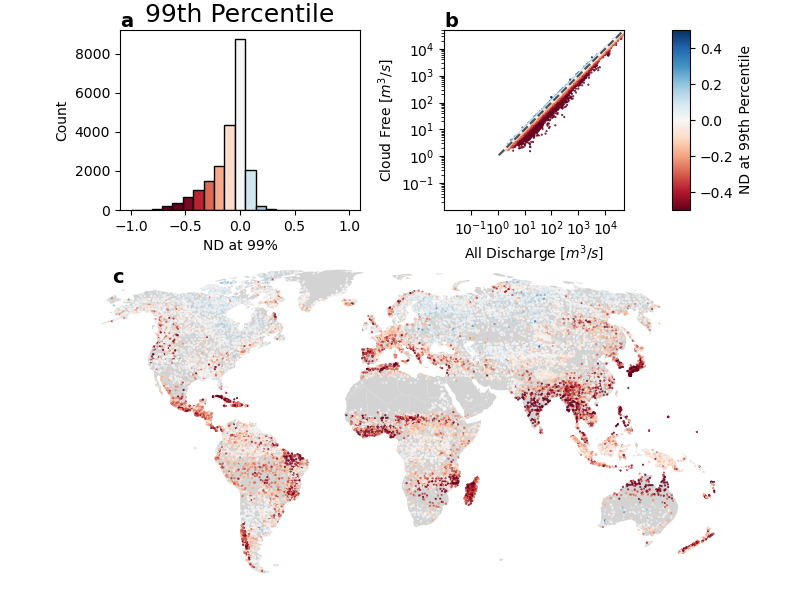

In [162]:
for q_str in tqdm(['01','10','90','99']):
    plt.close('all')
    fig = plt.figure(figsize=(8, 6))
    axes = dict()
    axes['left'] = fig.add_axes([0.15, 0.65, 0.3, 0.3])  # [left, bottom, width, height]
    axes['right'] = fig.add_axes([0.5, 0.65, 0.4, 0.3])
    axes['center'] = fig.add_axes([0.1, 0, 0.8, 0.65])
    
    ord_suffix = "st" if q_str=="01" else "th"

    #Histogram
    hist, bins = np.histogram(sites[f'normDiff_q{q_str}'], range=(-1, 1), bins=21)
    widths = np.diff(bins)

    # Create the histogram bars with colors according to the norm and cmap
    for h,b,w in zip(hist,bins,widths):
        color = plt.get_cmap(cmap)(norm(b+w/2)) # Normalize the histogram value and get the corresponding color
        axes['left'].bar(b, h, width=w, align='edge', color=color, edgecolor='black')
    axes['left'].set_xlabel(f"ND at {int(q_str)}%")
    axes['left'].set_ylabel("Count")

    #1:1 plot
    fp.obs_true_1to1(df,int(q_str),axes['right'])
    axes['right'].set_xlabel('All Discharge [$m^3/s$]')
    axes['right'].set_ylabel('Cloud Free [$m^3/s$]')
    axes['right'].set_xticks(np.logspace(-1,5,7))
    axes['right'].set_yticks(np.logspace(-1,5,7))
    axes['right'].set_xlim([1E-2,5E4])
    axes['right'].set_ylim([1E-2,5E4])

    # Plot world map                  
    world.plot(ax=axes['center'], color='lightgray')

    # Plot all sites on the center map
    sites.plot(ax=axes['center'], marker='o', column=f'normDiff_q{q_str}', markersize=0.25, cmap=cmap, norm=norm)

    # Add color bar
    fig.colorbar(mp.cm.ScalarMappable(norm=norm, cmap=cmap), 
                 ax = axes['right'], 
                 location = 'right',
                 pad = 0.15,
                 aspect = 10,
                 label = f"ND at {int(q_str)}{ord_suffix} Percentile")

    # axes['center'].set_title('Normalized Difference at Median',y=0.9)
    axes['center'].set_xlim([-1.4E7, 1.6E7])
    axes['center'].set_ylim([-6E6, 1E7])
    axes['center'].axis('off')

    axes['left'].text(0, 1.1, 'a', transform=axes['left'].transAxes, fontsize=14, fontweight='bold', va='top')
    axes['right'].text(0, 1.1, 'b', transform=axes['right'].transAxes, fontsize=14, fontweight='bold', va='top')
    axes['center'].text(0.05, 0.9, 'c', transform=axes['center'].transAxes, fontsize=14, fontweight='bold', va='top')
    
    axes['left'].set_title(f"{int(q_str)}{ord_suffix} Percentile", fontsize=18)

    fig.savefig(figure_path / "pub" / "supplemental" / f"GlobalStats_q{q_str}.png", format='png', dpi=600)

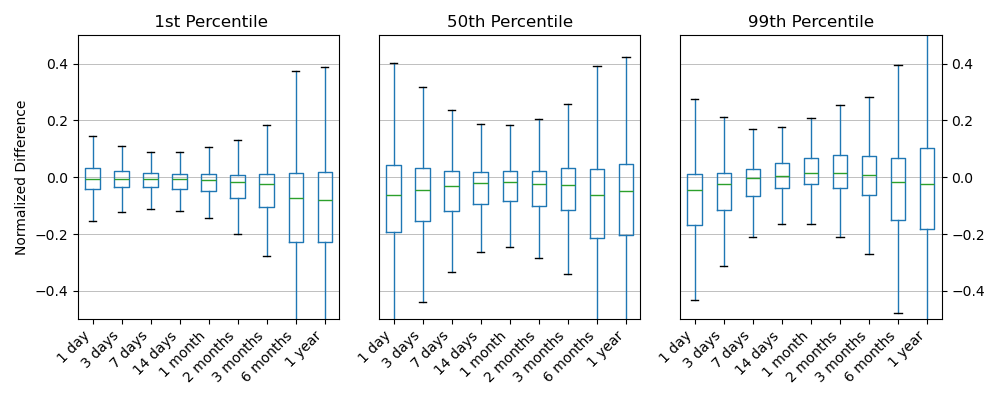

In [92]:
quants = [0.01, 0.50, 0.99]
windows = ['1D','3D','7D','14D','1ME','2ME','3ME','6ME','1YE']
window_labels = ['1 day', '3 days', '7 days','14 days', '1 month','2 months', '3 months', '6 months', '1 year']

plt.close("all")

fig, axes = plt.subplots(1,3,figsize=(10,4))
axes = axes.flatten() # Flatten the axes array for easy iteration

for ax, quant in zip(axes, quants):
    index = [f"{w}_{quant:1.2f}" for w in windows]
    
    tmp = resampled_sites[index].copy()
    for column in tmp.columns:
        tmp[column] = pd.to_numeric(tmp[column], errors='coerce')
    tmp.boxplot(ax=ax, showfliers=False)

    # Customize y-axis gridlines (only horizontal)
    ax.xaxis.grid(False)
    ax.yaxis.grid(True, linestyle='-', linewidth=0.5, color='grey', alpha=0.7)
    
    if quant == quants[0]:
        ax.set_ylabel("Normalized Difference")
    elif quant == quants[-1]:
        ax.yaxis.set_ticks_position('right')  # Remove y-axis ticks on the left
    else:
        ax.yaxis.set_ticks_position('none')  # Remove y-axis ticks on the left
        ax.yaxis.set_ticklabels([])  # Remove y-axis labels on the left
        
    
    ax.set_xticks(ticks=range(1,len(windows)+1),labels=window_labels, rotation=45, ha='right')
    ax.set_ylim([-0.5,0.5])
    
    ord_suffix = "st" if quant==0.01 else "th"
    ax.set_title(f"{quant*100:2.0f}{ord_suffix} Percentile")
    
plt.tight_layout()
plt.show()

if SAVE_PLOTS:
    fig.savefig(figure_path / "pub" / "supplemental" /  "resampling_boxplots", format='png', dpi=600)


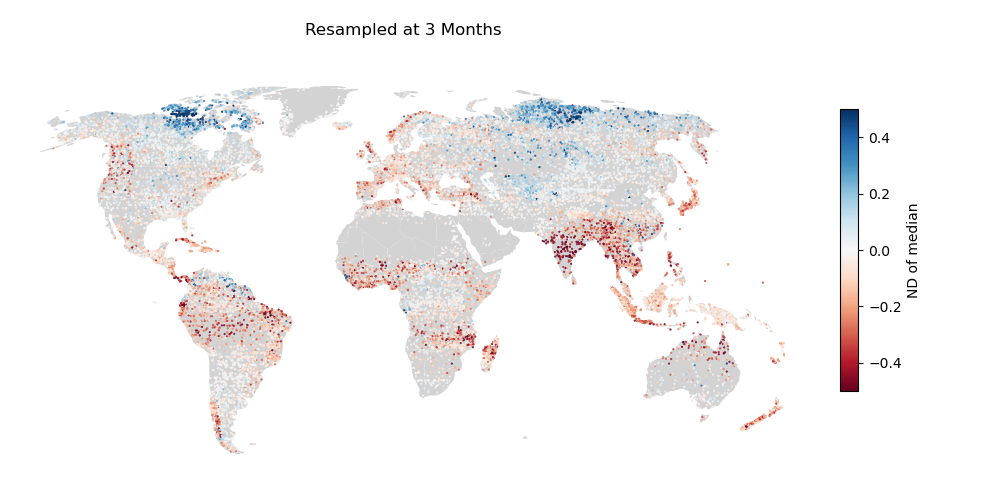

In [161]:
norm = TwoSlopeNorm(vmin=-0.5, vcenter=0, vmax=0.5)
cmap = 'RdBu'

cols = ['1D_0.50','1ME_0.50','3ME_0.50']
col_names = ["7 Days", "1 Month", "3 Months"]

for col, name in zip(cols, col_names):  
    plt.close('all')   
    fig = plt.figure(figsize=(10, 5))
    ax = fig.gca()

    world.plot(ax=ax, color='lightgray')

    # Plot all sites on the center map
    resampled_sites[col] = pd.to_numeric(resampled_sites[col], errors='coerce')
    resampled_sites.plot(ax=ax, marker='o', column=col, markersize=0.25, cmap=cmap, norm=norm)

    # Add color bar
    fig.colorbar(mp.cm.ScalarMappable(norm=norm, cmap=cmap), 
                 ax = ax, 
                 location = 'right',
                 pad = 0.05,
                 aspect = 15,
                 shrink=0.6,
                 label = 'ND of median')

    ax.set_xlim([-1.4E7, 1.6E7])
    ax.set_ylim([-6E6, 1E7])
    ax.axis('off')
    
    plt.title(f"Resampled at {name}")
    plt.tight_layout()

    if SAVE_PLOTS:
        fig.savefig(figure_path / "pub" / "supplemental" / f"resampled_{name}.png", format='png', dpi=600)
     